<b><font size=20, color='#A020F0'>xgcm</font></b>

Hannah Zanowski<br>
11/11/24<br>

#### <span style="color:green">Learning Goals</span>
By the end of this notebook you will
1. Become familiar with the standard discretizations for climate model grids
2. Understand the basic data structures in xgcm and how to create them
3. Practice using xgcm to do grid-aware calculations with climate model output

#### Resources
[xgcm Documentation](https://xgcm.readthedocs.io/en/latest/index.html)<br>
[xgcm API](https://xgcm.readthedocs.io/en/latest/api.html)

#### Acknowledgements
Much of today's lecture borrows from the examples on the [xgcm website](https://xgcm.readthedocs.io/en/latest/index.html)

# A little about xgcm

xgcm is a package developed for working with general circulation model (GCM) output. Like many of the packages we've seen before, it uses xarray under the hood. The power of xgcm is that it allows you to do grid-aware computations on your data, which you'll almost certainly need when working with climate model output.

Let's begin by importing xgcm (and a few others):

In [1]:
import xgcm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

---

## 1. Climate model grids

Climate models integrate the discretized Navier-Stokes equations. There are a number of ways in which you can set up the discretizations, but the most common are those below, and they are known as the Arakawa grids (see, e.g., [Arakawa and Lamb 1977](https://www.sciencedirect.com/science/article/pii/B9780124608177500094#bbib1)). Different grids have different properties and behaviors when it comes to integrating, which is why there are several options. We will not go into those details here as they are more suited to a numerical methods class.

<img src='Images/Arakawa_grids.png' width='750' height='750'/>

B and C-grid discretizations are the most common among ocean models, and many use the C-grid because of its conservation properties. In either case, the velocity and scalar/tracer points are staggered relative to each other, which means that their spatial coordinates (longitudes and latitudes) are not the same. 

This means that if you want to do, say, computations that involve scalars and velocities (advection, anyone?), you need to interpolate your scalar points or your velocity points so that they will be co-located. At the same time, <b>standard operations such as averaging, differencing, and derivatives shift your output by half a grid cell relative to the inputs (this is related to [finite differencing](https://en.wikipedia.org/wiki/Finite_difference))</b>. Keeping track of this can get really frustrating really fast, so that's where xgcm comes in. But before we do that let's stop and think about things for a moment.

---

#### <font color='blue'>Question for the class</font>
The vertical component of relative vorticity is

$\zeta=\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}$

If you were to do this computation on each of the five grids, where would the result of each derivative be located (assume x and y are in their standard directions)? Are there any grids where your derivatives are co-located? If so which one(s)?

---

## 2. Getting started with xgcm
xgcm helps you keep track of the different grid cell locations in climate model output by leveraging relationships between the discretized fields.

### xgcm axes
xgcm heavily relies on the notion of axes. For a single <b>physical axis</b> (e.g. longitude) there can be multiple <b>_coordinate axes_</b> associated with it that describe positions relative to a grid cell. The five positions that xgcm currently supports throug [xgcm.Axis](https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Axis) are the following:

1. `center`: points fall at the center of a grid cell
2. `left`: points fall on the left or lower face of a grid cell
3. `right`: points fall on the right or upper face of a grid cell
4. `inner`: points are located on cell faces, excluding all outer boundaries
5. `outer`: points are located on cell faces, including all outer boundaries

Here is a visualization of each from the xgcm site:<br>
<center><img src='https://xgcm.readthedocs.io/en/latest/_images/axis_positions.svg'></img></center>

From your regridding exercises in last week's in-class notebook, you are familiar with the `center` and `outer` axes options--these correspond to your data lat/lons and their bounds, respectively.

### Creating an xgcm grid
[xgcm.Grid objects](https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid) are the core data structure in xgcm. They consist of <b>_multiple coordinates_</b> associated with the same <b>physical axis</b>. xgcm keeps track of how the coordinates are related so that operations with your data are grid-aware.

<b>When creating an xgcm grid, you need to do the following:</b>
>1. Provide xgcm with an xarray dataset that contains all of the coordinates for the different axes that are connected to your data
>2. Tell xgcm how the coordinates are related by noting the positions (left, outer, etc) they occupy

This can be done by hand or by having xgcm look for certain attributes in your dataset. We'll build our own grid from scratch below. First we'll create an xarray Dataset with one physical axis, but two coordinates, `x_c` and `x_g`, which represent the x-axis locations of the cell centers and the left cell edges, respectively:

In [2]:
dsg=xr.Dataset(coords={'x_c': (['x_c',], np.arange(0, 360),),'x_g': (['x_g',],np.arange(-0.5,359))})
dsg

<xarray.Dataset>
Dimensions:  (x_c: 360, x_g: 360)
Coordinates:
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * x_g      (x_g) float64 -0.5 0.5 1.5 2.5 3.5 ... 355.5 356.5 357.5 358.5
Data variables:
    *empty*

In the above dataset, xarray has no idea that x_c and x_g are related, but they clearly are: each x_g is half a point to the left of each x_c:

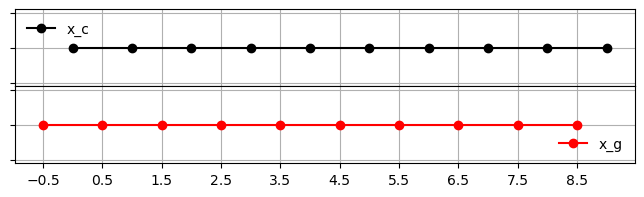

In [3]:
xpts=0.5*np.ones(10)
fig,ax=plt.subplots(2,1,figsize=(8,2),sharex=True)
axs=ax.flatten()
axs[0].plot(dsg.x_c[0:10],xpts,color='k',marker='o',label='x_c')
axs[0].legend(frameon=False,loc='upper left')
axs[0].set_yticklabels('')
axs[0].set_xticks(np.arange(-0.5,10))
axs[0].grid()
axs[1].plot(dsg.x_g[0:10],xpts,color='r',marker='o',label='x_g')
axs[1].legend(frameon=False, loc='lower right')
plt.subplots_adjust(hspace=0)
axs[1].set_yticklabels('');
axs[1].grid()

When we create an xgcm grid, we can specify that x_c and x_g are related (and we must) through the `coords` argument:

In [4]:
#Tell the grid that both x_c and x_g are coordinates and both are on the 'x' axis
grid=xgcm.Grid(dsg, coords={'x': {'center': 'x_c', 'left': 'x_g'}})
grid

<xgcm.Grid>
x Axis (periodic, boundary=None):
  * center   x_c --> left
  * left     x_g --> center

<b>The arrows indicate how your grid will change when doing computations that will result in your original data being shifted (such as interpolation and differencing):</b>

1. For these types of computations on cell centers (x_c), the results will be on the x_g grid
2. For these types of computations on cell edges (x_g), the results will be on the x_c grid

><b><font color ='red'>Note:</font></b> xgcm.Grid assumes that all axes are periodic unless you specify differently with the `periodic` keyword argument!

### Creating an xgcm grid from data attributes
You can also create an xgcm grid as long as your data have two attributes defined that xgcm needs to build the grid:
1. `axis`
2. `c_grid_axis_shift` (valid options for this attribute are only -0.5 and 0.5)

In [5]:
#Set up the dataset but this time with axis and x_grid_axis_shift attributes
dsg=xr.Dataset(coords={'x_c': (['x_c',], np.arange(0,360),{'axis': 'x'}),
    'x_g': (['x_g',],np.arange(-0.5,359),{'axis':'x', 'c_grid_axis_shift': -0.5})})

In [6]:
#Create the grid
grid=xgcm.Grid(dsg)
grid

<xgcm.Grid>
x Axis (periodic, boundary=None):
  * center   x_c --> left
  * left     x_g --> center

### Grid-aware computations
Now that we have our xgcm grid set up, we can create some data and do some grid-aware computations

In [7]:
#set up some values that are defined at the cell centers (x_c points)
data=np.sin(dsg.x_c*np.pi/180)
data[0:10]

<xarray.DataArray 'x_c' (x_c: 10)>
array([0.        , 0.01745241, 0.0348995 , 0.05233596, 0.06975647,
       0.08715574, 0.10452846, 0.12186934, 0.1391731 , 0.15643447])
Coordinates:
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 9

#### Differencing
You can difference your data with [grid.diff()](https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid.diff)

><b><font color='red'>Note:</font></b> When doing xgcm grid operations, we must provide the axis over which we want to do the computation

In [8]:
data_diff=grid.diff(data,axis='x')
data_diff[0:5]

<xarray.DataArray 'x_c' (x_g: 5)>
array([0.01745241, 0.01745241, 0.01744709, 0.01743646, 0.01742052])
Coordinates:
  * x_g      (x_g) float64 -0.5 0.5 1.5 2.5 3.5

#### Interpolating
You can interpolate your data using [grid.interp()](https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid.interp)

In [9]:
data_interp=grid.interp(data,axis='x')
data_interp[0:5]

<xarray.DataArray 'x_c' (x_g: 5)>
array([-0.0087262 ,  0.0087262 ,  0.02617595,  0.04361773,  0.06104621])
Coordinates:
  * x_g      (x_g) float64 -0.5 0.5 1.5 2.5 3.5

---

## 3. Using xgcm with climate model output
At this point you are probably wondering why I made you go through all that work just to show you that you can interpolate with xgcm, when we've already covered several other options in this class that allow us to interpolate and difference, etc. At best, xgcm seems like overkill. However, the examples above are only meant to be illustrative so that you can get a sense of what xgcm is doing before things get more complex. In reality you probably wouldn't use xgcm for something like the above cases, even though you could. In this section we'll work with some ocean output from the [Community Earth System Model Large Ensemble](https://www.cesm.ucar.edu/) (CESM-LE) so that you can see how xgcm is useful in the context for which it was designed.

Let's read in some data:

In [10]:
ds=xr.open_dataset('data/cesmLE.001.ocn.210012.nc')
ds

<xarray.Dataset>
Dimensions:      (z_t: 60, yt: 384, xt: 320, yu: 384, xu: 320, z_w: 60,
                  z_w_top: 60, z_w_bot: 60)
Coordinates:
    time         object ...
  * z_t          (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG        (yt, xt) float64 ...
    TLAT         (yt, xt) float64 ...
    ULONG        (yu, xu) float64 ...
    ULAT         (yu, xu) float64 ...
  * z_w          (z_w) float32 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_top      (z_w_top) float32 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: yt, xt, yu, xu
Data variables: (12/15)
    TEMP         (z_t, yt, xt) float32 ...
    UVEL         (z_t, yu, xu) float32 ...
    VVEL         (z_t, yu, xu) float32 ...
    dz           (z_t) float32 ...
    DXT          (yt, xt) float64 ...
    DYT          (yt, xt) float64 ...
    ...           ...
    DYU          (yu, xu) float64 ...
    HTE          (yt, xu) float64 ...
    HTN          (yu, xt) float64 ...
    HUW          (yu, xt) float64 ...
    HUS          (yt, xu) float64 ...
    REGION_MASK  (yu, xu) float64 ...

### Creating the xgcm grid

The CESM ocean model (currently [POP2](https://www.cesm.ucar.edu/models/cesm2/ocean), but that's changing) is on a B-grid. In the image below, you can see how each of the quantities in the dataset are related to each other:

<img src='Images/cesm_b_grid_cells.png' width='500' height='500'/>

Based on this information, let's set up the xgcm grid for our model output below. This time we have 3-D output so we'll have information for the x, y, and z axes:

In [11]:
grid=xgcm.Grid(ds, coords={'x': {'center': 'xt', 'right': 'xu'},
                           'y':{'center':'yt','right':'yu'},
                           'z':{'center':'z_t','right':'z_w'}},periodic=['x'])

grid

<xgcm.Grid>
x Axis (periodic, boundary=None):
  * center   xt --> right
  * right    xu --> center
y Axis (not periodic, boundary=None):
  * center   yt --> right
  * right    yu --> center
z Axis (not periodic, boundary=None):
  * center   z_t --> right
  * right    z_w --> center

### Grid-aware computations again

Now that we have our grid we can do computations like we did before. As a simple example, let's interpolate the temperature field onto the locations of the velocities. Because the ouput is on a B-grid, we need to interpolate in x and y to do so:

In [12]:
temp_interp=grid.interp(ds.TEMP,axis=['x','y'],boundary='fill') #provide both axes and a boundary option for the non-periodic y-direction

Let's make sure our output is on the velocity grid:

In [13]:
temp_interp.dims

('z_t', 'yu', 'xu')

And now let's plot it:

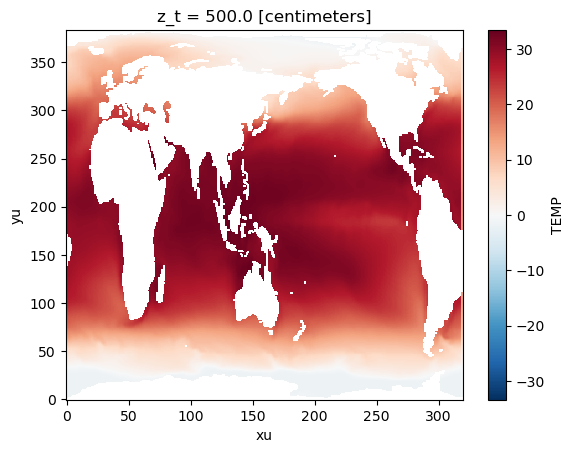

In [14]:
temp_interp.isel(z_t=0).plot()

### Metrics
xgcm also handles grid metrics. Metrics provide information about grid cell geometry--things like distances, areas, and volumes. By keeping track of the grid metrics, xgcm can use these when doing computations where these weights are necessary. As usual, we need to tell xgcm what these metrics are and then add them to the xgcm grid. Fortunately for us, these metrics are standard for CESM output so we won't have to compute them.

In xgcm, grid metrics are stored in a dictionary that maps them to the particular axis they are associated with:

In [15]:
grid_metrics = {('x',): ['DXU', 'DXT','HTN','HUS'], # grid cell widths in x-direction
           ('y',): ['DYU', 'DYT','HTE','HUW'], # grid cell widths in y-direction
           ('z',): ['dz'], # grid cell width in z-direction     
           ('x', 'y'): ['UAREA', 'TAREA']} # Areas of velocity and tracer grid cells, respectively

Once you have your metrics, all you need to do is add them to the grid. Here we're creating the same grid we did earlier, but now with the `metrics` keyword argument

In [16]:
grid=xgcm.Grid(ds, coords={'x': {'center': 'xt', 'right': 'xu'},
                           'y':{'center':'yt','right':'yu'},
                           'z':{'center':'z_t','right':'z_w'}},
                           periodic=['x'],metrics=grid_metrics)

#### Integration
We can integrate with [grid.integrate()](https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid.integrate)

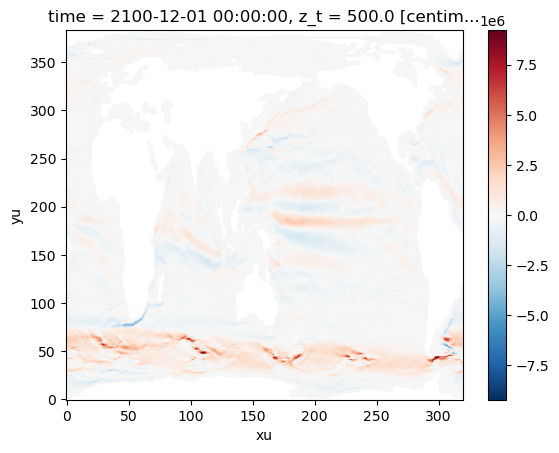

In [17]:
#Vertically integrate the zonal velocity as an example
#Quick land mask first
land=np.isnan(ds.UVEL[0])
grid.integrate(ds.UVEL, 'z').where(~land).plot()

#this is the same as
#(ds.UVEL*ds.dz).sum('z_t').plot()

#### Weighted averages
For weighted averages, use [grid.average()](https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid.average). When it comes to averaging, xgcm will automatically do a weighted mean now that the grid has metrics. This is really important, especially if your grid is not evenly spaced, which is the case for the x, y, and z directions in this model!

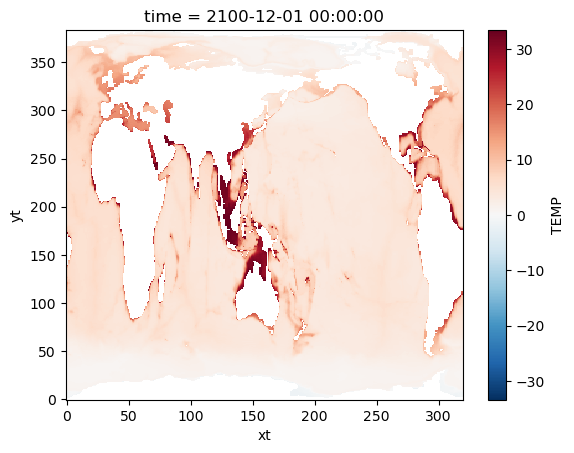

In [18]:
grid.average(ds.TEMP, 'z').plot()

#### Revisiting Vorticity
We can also do more complex operations, like computing the relative vorticity. In case you forgot, the vertical component of relative vorticity is <br>

$\zeta=\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}$

As we saw earlier, this is a somewhat irritating calculation on a B-grid because of the co-located velocities. Once you compute the derivatives, the results won't be at the same grid locations anymore, so you need to interpolate them before you can do the difference.

1. Compute the derivatives

In [19]:
#compute dv/dx and du/dy
dvdx=grid.diff(ds.VVEL.isel(z_t=0), 'x', metric_weighted='x', boundary='fill')/ds.HTN
dudy=grid.diff(ds.UVEL.isel(z_t=0), 'y', metric_weighted='y', boundary='fill')/ds.HTE

2. Interpolate onto tracer points

In [20]:
#Interpolate onto the tracer points
dvdx_interp=grid.interp(dvdx,axis='y',metric_weighted='y',boundary='fill')
dudy_interp=grid.interp(dudy,axis='x',metric_weighted='x')

3. Make sure you're on the grid you think you are

In [21]:
#Check that I'm not making shit up
dudy_interp.dims

('yt', 'xt')

4. Compute the relative vorticity

In [22]:
#Compute the relative vorticity
zeta=dvdx_interp-dudy_interp

5. Make a plot of your results!

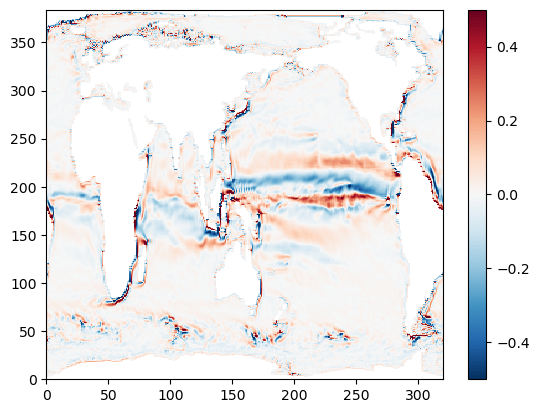

In [23]:
#Plot it
plt.pcolormesh(zeta*1e5,vmin=-0.5,vmax=0.5,cmap=plt.cm.RdBu_r)
plt.colorbar()

---